In [1]:
# %% 
# import all packages
# import ipywidgets
# print(ipywidgets.__version__)

import json
from datetime import datetime

import pandas as pd
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm_notebook

from flexABLE import World

from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

tqdm_notebook.pandas()

In [2]:
# Cell 2: Load Scenario Configuration
scenario_file = 'single_agent_policy_test.json'
with open(f'./scenarios/single_agent/{scenario_file}') as f:
    config = json.load(f)
    scenario = config['run_single_agent_test']


In [3]:
# Cell 3: Setup the Simulation Environment
save_policy_dir = 'policies/'

dt = scenario['dt']

snapLength = int(24/dt*scenario['days'])
timeStamps = pd.date_range(f"{scenario['year']}-01-01T00:00:00", f"{scenario['year'] + 1}-01-01T00:00:00", freq='15T')

starting_point = str(scenario['year'])+scenario['start']
starting_point = timeStamps.get_loc(starting_point)

world = World(snapshots=snapLength,
              scenario=scenario['scenario'],
              simulation_id=scenario['id'],
              starting_date=timeStamps[starting_point],
              dt=dt,
              enable_CRM=False,
              enable_DHM=False,
              check_availability=False,
              max_price=scenario['max_price'],
              write_to_db=scenario['write_to_db'],
              rl_mode=scenario['rl_mode'],
              cuda_device=0,
              save_policies=True,
              save_params={'save_dir': save_policy_dir},
              load_params=scenario['load_params'],
              learning_params = scenario['learning_params'])

In [4]:
# Load scenario
world.load_scenario(startingPoint=starting_point,
                    importStorages=scenario['import_storages'],
                    opt_storages=scenario['opt_storages'],
                    importCBT=scenario['importCBT'],
                    scale=scenario['scale'])

rl_explainable = scenario['rl_explainable']

INFO:Simulation ID:single_agent_policy_test_01
INFO:Loading scenario: single_agent_policy_test
INFO:Loading fuel data...
INFO:Loading agents and assets...
INFO:Loading demand and creating EOM...
INFO:Calculating marginal costs...
INFO:Calculating PFC...
INFO:Preparing RL...
INFO:Training mode active, MATD3 algorithm created
INFO:Running on cpu
INFO:All data loaded, ready to run the simulation
INFO:################


In [5]:
# Log the state of RL agents
print(f"RL Powerplants: {len(world.rl_powerplants)}")
print(f"RL Storages: {len(world.rl_storages)}")

RL Powerplants: 0
RL Storages: 1


In [6]:
def compute_saliency_map(state, policy_model):
    state = Variable(state.float(), requires_grad=True)

    # Set the model to evaluation mode
    policy_model.eval()
    
    # Forward pass to compute action scores
    action_scores = policy_model(state)
    
    # Sum the action scores to get a scalar for computing gradients
    action_scores_summed = action_scores.sum()
    
    # Compute gradients for the action scores with respect to the input state
    action_scores_summed.backward()
    
    # Get the gradient of the action scores with respect to the input state
    # This gradient is the saliency map
    saliency_map = state.grad.data
    
    return saliency_map

INFO:################
INFO:Training started at: 2024-01-10 20:58:23.369119


Training:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

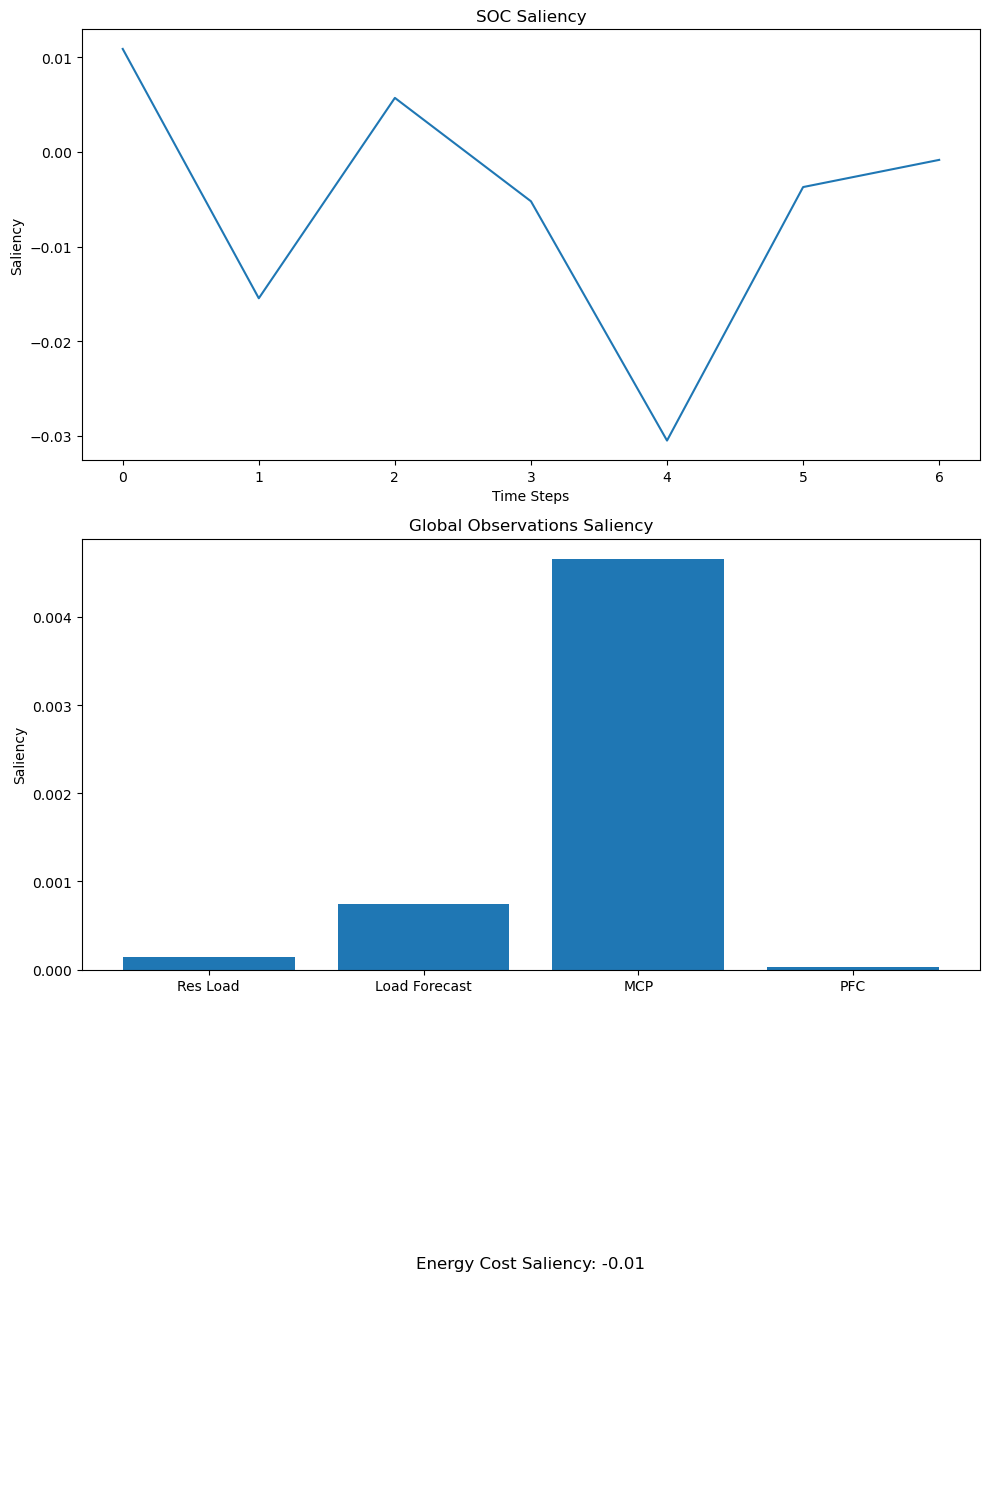

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

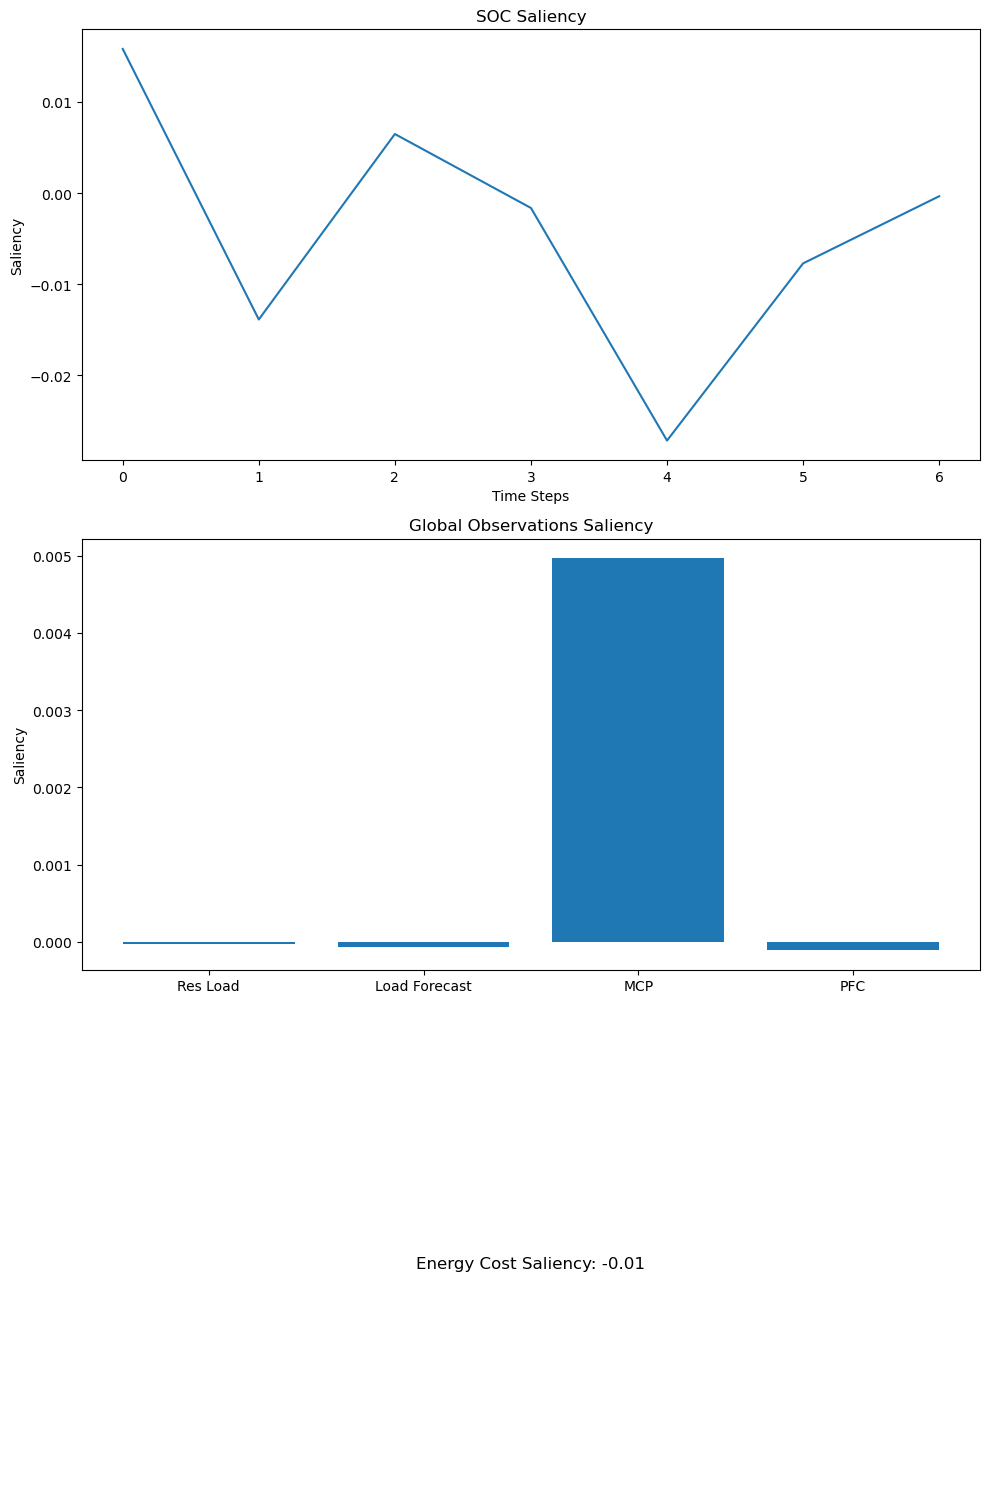

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

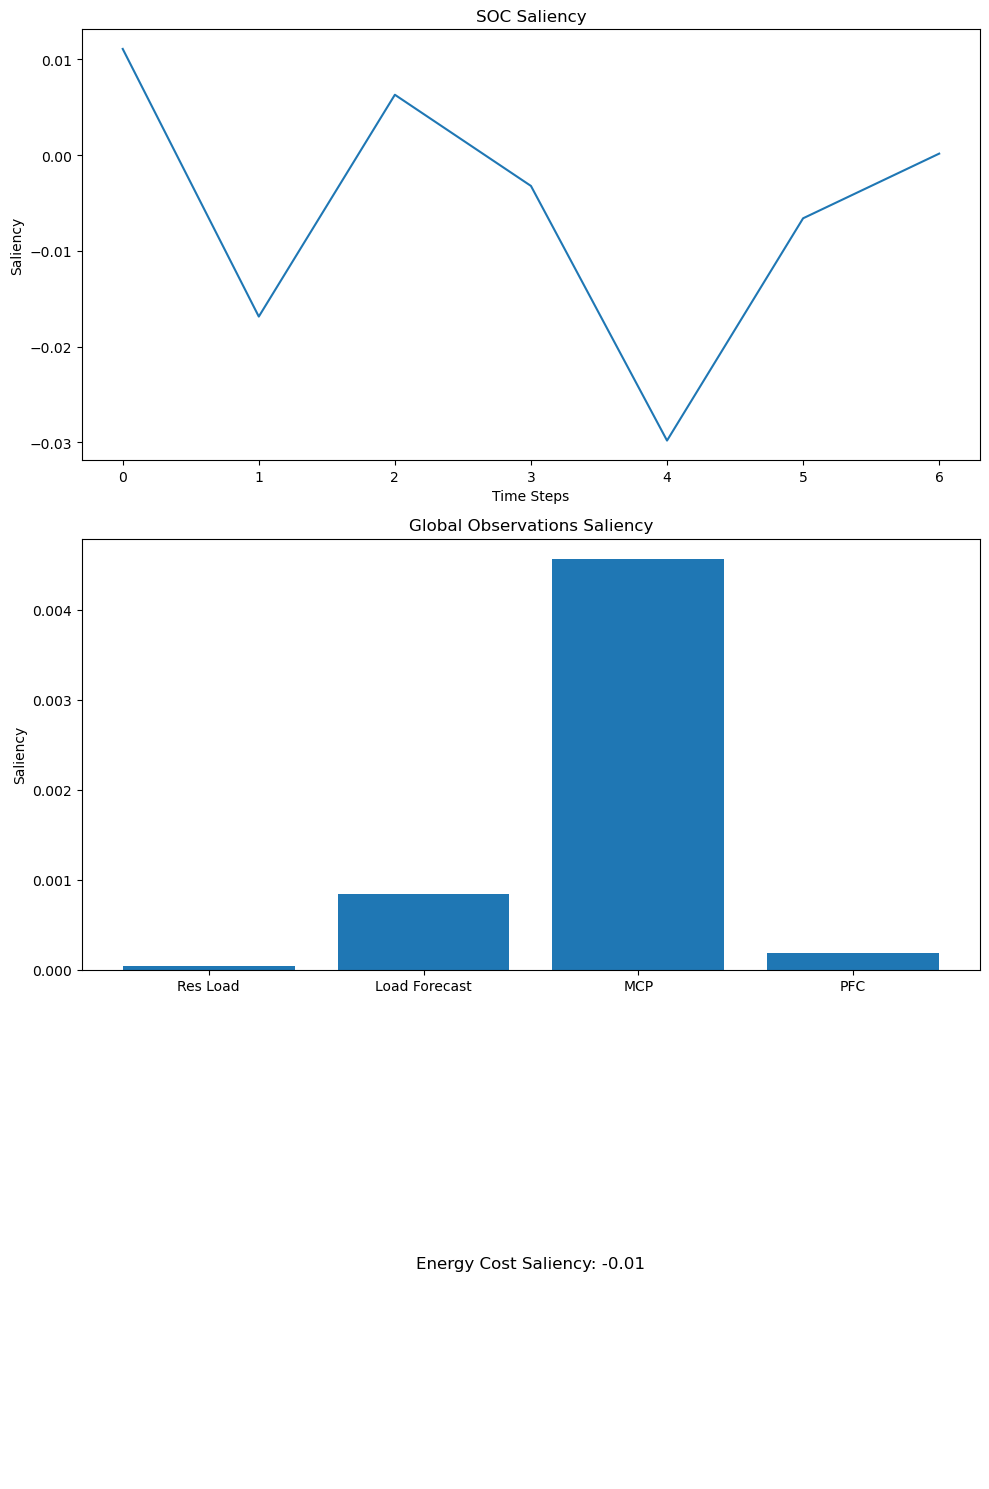

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

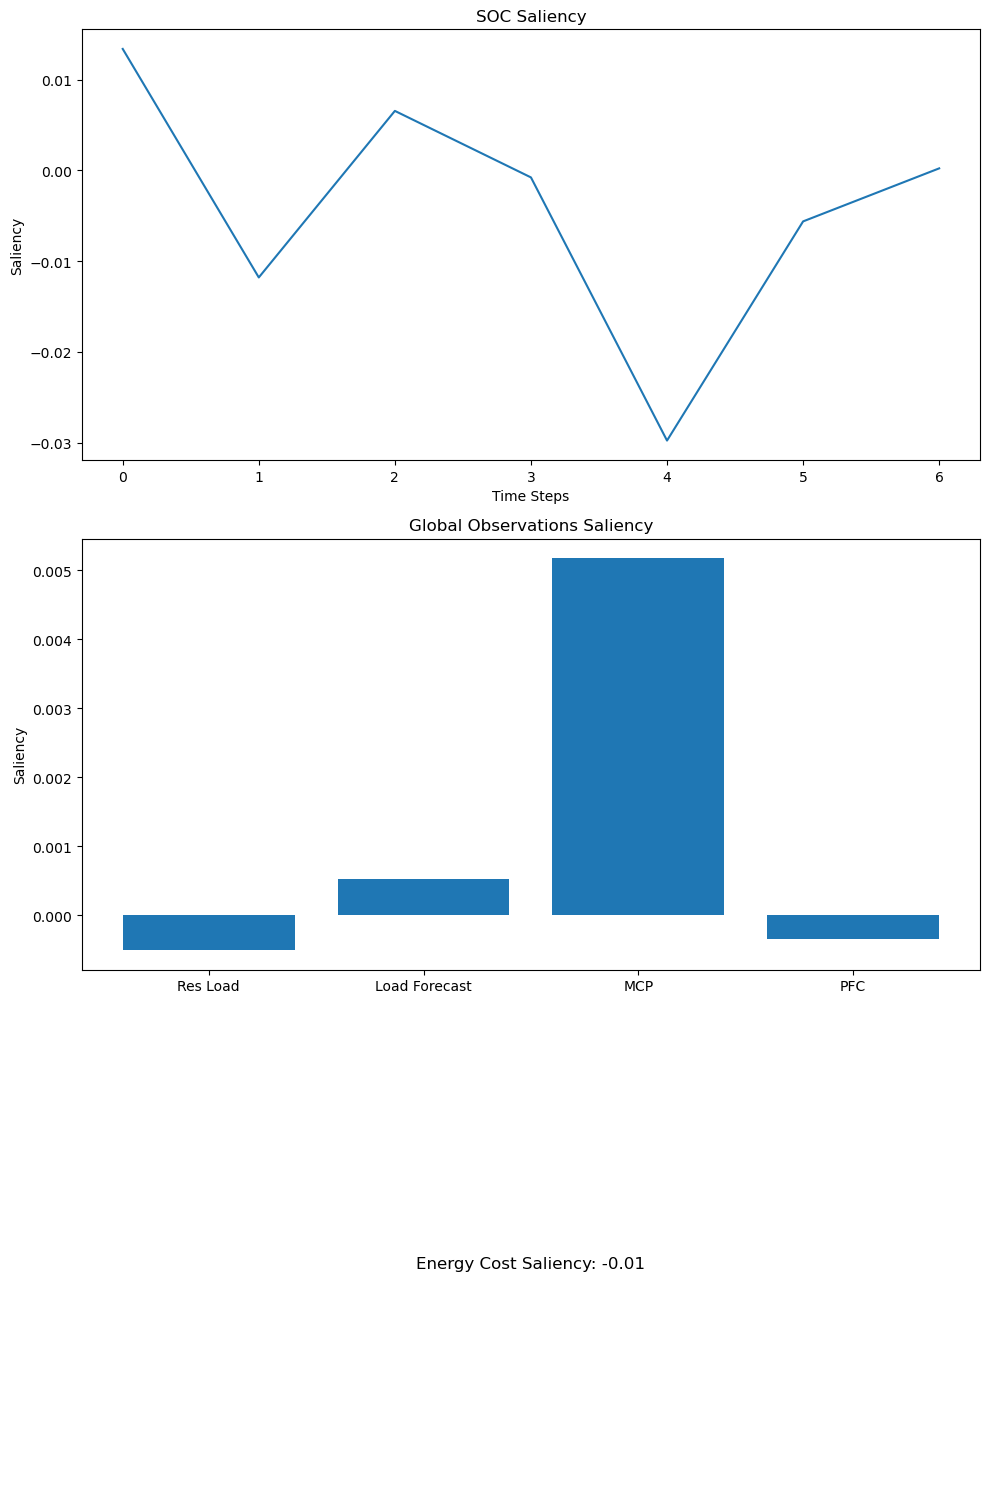

INFO:################
INFO:Training time: 0:01:21.077404


  0%|          | 0/720 [00:00<?, ?it/s]

INFO:Saving results into CSV files...
INFO:Saving results complete
INFO:################
INFO:Average reward: 0.0634117068806576
INFO:Average profit: 7.9264633600822005
INFO:Average regret: 0.0


In [7]:
# Start simulation
index = pd.date_range(world.starting_date, periods=len(world.snapshots), freq=f'{str(60 * world.dt)}T')

if world.rl_mode and world.training:
    training_start = datetime.now()
    world.logger.info("################")
    world.logger.info(f'Training started at: {training_start}')

    learning_params = scenario['learning_params']
    training_episodes = learning_params['training_episodes']

    for i_episode in tqdm(range(training_episodes), desc='Training'):
        start = datetime.now()
        world.run_simulation()
        world.episodes_done += 1

        if ((i_episode + 1) % 5 == 0) and world.episodes_done > learning_params['learning_starts']:
            world.training = False
            world.run_simulation()
            world.compare_and_save_policies()
            world.eval_episodes_done += 1
            world.training = True

            if world.write_to_db:
                tempDF = pd.DataFrame(world.mcp, index=index, columns=['Simulation']).astype('float32')
                world.results_writer.writeDataFrame(tempDF, 'Prices', tags={'simulationID': world.simulation_id, "user": "EOM"})

        # Explainable AI:
        # Compute and log saliency maps at specific intervals or episodes
        # Currently, we compute saliency maps using rlstorage's obs for the single RL storage agent
        
        if i_episode % 5 == 0:  # For example, every 5 episodes
            # for unit in world.rl_powerplants + world.rl_storages:
            unit = world.rl_storages[0]
            policy_model = unit.actor
            current_state = unit.curr_obs  # Current observation of the RL storage unit
            
            # Assuming the first agent in rl_storages is the one of interest
            unit = world.rl_storages[0]
            policy_model = unit.actor
            current_state = unit.curr_obs  # Using unit-specific state
            saliency_map = compute_saliency_map(current_state, policy_model)
            # world.logger.info(f"Saliency Map for unit {unit.name} at episode {i_episode}: {saliency_map}")

            # Convert saliency map to numpy for plotting
            saliency_map_np = saliency_map.cpu().detach().numpy()

            # Segments
            soc_saliency = saliency_map_np[:7]
            energy_cost_saliency = saliency_map_np[7]
            global_obs_saliency = saliency_map_np[8:]  # Large segment (120 elements)

            # Simplifying global observations by averaging each component
            avg_global_saliency = np.mean(global_obs_saliency.reshape(-1, 30), axis=1)

            # Plotting
            fig, axs = plt.subplots(3, 1, figsize=(10, 15))
            fig.tight_layout()

            # SOC Saliency
            axs[0].plot(range(7), soc_saliency)
            axs[0].set_title('SOC Saliency')
            axs[0].set_xlabel('Time Steps')
            axs[0].set_ylabel('Saliency')

            # Energy Cost Saliency
            axs[2].text(0.5, 0.5, f'Energy Cost Saliency: {energy_cost_saliency:.2f}', 
                        horizontalalignment='center', verticalalignment='center', fontsize=12,
                        transform=axs[2].transAxes)
            axs[2].axis('off')  # Turn off axis for text display

            # Global Observations Saliency
            axs[1].bar(['Res Load', 'Load Forecast', 'MCP', 'PFC'], avg_global_saliency)
            axs[1].set_title('Global Observations Saliency')
            axs[1].set_ylabel('Saliency')

            plt.tight_layout()
            plt.show()
                 
    # for unit in world.rl_powerplants + world.rl_storages:
    unit = world.rl_storages[0]
    policy_model = unit.actor
    current_state = unit.curr_obs  # Current observation of the RL storage unit
    
    # Assuming the first agent in rl_storages is the one of interest
    unit = world.rl_storages[0]
    policy_model = unit.actor
    current_state = unit.curr_obs  # Using unit-specific state
    saliency_map = compute_saliency_map(current_state, policy_model)
    # world.logger.info(f"Saliency Map for unit {unit.name} at episode {i_episode}: {saliency_map}")

    # Convert saliency map to numpy for plotting
    saliency_map_np = saliency_map.cpu().detach().numpy()

    # Segments
    soc_saliency = saliency_map_np[:7]
    energy_cost_saliency = saliency_map_np[7]
    global_obs_saliency = saliency_map_np[8:]  # Large segment (120 elements)

    # Simplifying global observations by averaging each component
    avg_global_saliency = np.mean(global_obs_saliency.reshape(-1, 30), axis=1)

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    fig.tight_layout()

    # SOC Saliency
    axs[0].plot(range(7), soc_saliency)
    axs[0].set_title('SOC Saliency')
    axs[0].set_xlabel('Time Steps')
    axs[0].set_ylabel('Saliency')

    # Energy Cost Saliency
    axs[2].text(0.5, 0.5, f'Energy Cost Saliency: {energy_cost_saliency:.2f}', 
                horizontalalignment='center', verticalalignment='center', fontsize=12,
                transform=axs[2].transAxes)
    axs[2].axis('off')  # Turn off axis for text display

    # Global Observations Saliency
    axs[1].bar(['Res Load', 'Load Forecast', 'MCP', 'PFC'], avg_global_saliency)
    axs[1].set_title('Global Observations Saliency')
    axs[1].set_ylabel('Saliency')

    plt.tight_layout()
    plt.show()
       
    world.rl_algorithm.save_params(dir_name = 'last_policy')
    for unit in world.rl_powerplants+world.rl_storages:
        unit.save_params(dir_name = 'last_policy')

    training_end = datetime.now()
    world.logger.info("################")
    world.logger.info(f'Training time: {training_end - training_start}')
    
    world.training=False
    world.run_simulation()

    if world.write_to_db:
        world.results_writer.save_results_to_DB()
    else:
        world.results_writer.save_result_to_csv()
    
    world.logger.info("################")

else:
    start = datetime.now()
    world.run_simulation()
    end = datetime.now()
    world.logger.info(f'Simulation time: {end - start}')

    if world.write_to_db:
        world.results_writer.save_results_to_DB()
    else:
        world.results_writer.save_result_to_csv()

if world.rl_mode:
    world.logger.info(f'Average reward: {world.rl_eval_rewards[-1]}')
    world.logger.info(f'Average profit: {world.rl_eval_profits[-1]}')
    world.logger.info(f'Average regret: {world.rl_eval_regrets[-1]}')
else:
    world.logger.info(f'Average reward: {world.conv_eval_rewards[-1]}')
    world.logger.info(f'Average profit: {world.conv_eval_profits[-1]}')
    world.logger.info(f'Average regret: {world.conv_eval_regrets[-1]}')
